# Zebrafish pigmentation

This tutorial uses data from [Saunders, et al (2019)](https://elifesciences.org/articles/45181). Special thanks also go to [Lauren](https://twitter.com/LSaund11) for the tutorial improvement. 

In this [study](https://elifesciences.org/articles/45181), the authors profiled thousands of neural crest-derived cells from trunks of post-embryonic zebrafish. These cell classes include pigment cells, multipotent pigment cell progenitors, peripheral neurons, Schwann cells, chromaffin cells and others. These cells were collected during an active period of post-embryonic development, which has many similarities to fetal and neonatal development in mammals, when many of these cell types are migrating and differentiating as the animal transitions into its adult form. This study also explores the role of thyroid hormone (TH), a common endocrine factor, on the development of these different cell types. 

Such developmental and other dynamical processes are especially suitable for dynamo analysis as dynamo is designed to accurately estimate direction and magnitude of expression dynamics (`RNA velocity`), predict the entire lineage trajectory of any intial cell state (`vector field`), characterize the structure (`vector field topology`) of full gene expression space, as well as fate commitment potential (`single cell potential`). 

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn 
from dynamo.configuration import DKM
import numpy as np
celltype_key = "Cell_type"

this is like R's sessionInfo() which helps you to debug version related bugs if any. 

## Load data

In [2]:
import scipy
from scipy.sparse import issparse, csr_matrix

adata = dyn.sample_data.zebrafish()
adata.X = adata.layers["spliced"]
adata.X = csr_matrix(adata.X)
adata_origin = dyn.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> Downloading data to ./data/zebrafish.h5ad


## Apply pearson residual normalization on different layers according `select_genes_key`. We may use other select_genes function combined with pearson residual normalization.

In [3]:
# adata = dyn.sample_data.zebrafish()
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(adata)
preprocessor.filter_cells_by_outliers = None
preprocessor.filter_genes_by_outliers = None
preprocessor.normalize_by_cells = None
preprocessor.select_genes_function = pearson_residual_normalization_recipe.select_genes_by_pearson_residual
preprocessor.normalize_selected_genes_function = pearson_residual_normalization_recipe.normalize_layers_pearson_residuals
# preprocessor.use_log1p = True
# preprocessor.preprocess_adata(adata)

preprocessor.select_genes_function(adata, n_top_genes=2000)
# preprocessor.normalize_selected_genes_function(adata)
preprocessor.pca(adata, pca_key="X_pca",n_pca_components=50)


|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----> gene selection on layer: X
|-----> extracting highly variable genes


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

In [4]:
import scanpy as sc
import dynamo as dyn

sc_adata = dyn.sample_data.zebrafish()
sc_adata.X = sc_adata.layers["spliced"]
sc.experimental.pp.recipe_pearson_residuals(sc_adata, n_comps=50, n_top_genes=2000)

|-----> Downloading data to ./data/zebrafish.h5ad


In [5]:
sc_adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

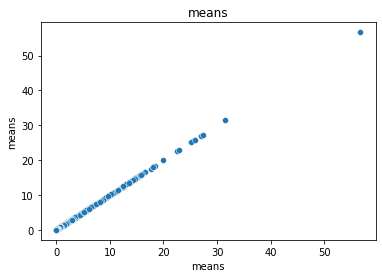

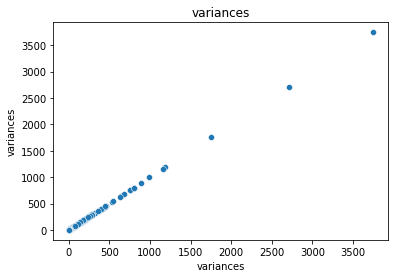

Text(0.5, 1.0, 'residual_variances')

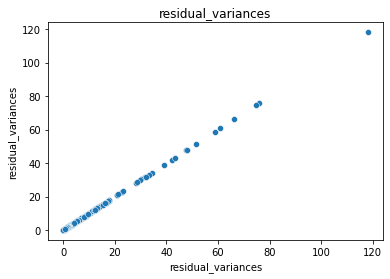

In [6]:
sns.scatterplot(adata.var["means"], sc_adata.var["means"]).set_title("means")
plt.show()
plt.clf()
sns.scatterplot(adata.var["variances"], sc_adata.var["variances"]).set_title("variances")
plt.show()
plt.clf()
sns.scatterplot(adata.var["residual_variances"], sc_adata.var["residual_variances"]).set_title("residual_variances")


dyn X_pca shape: (4181, 50)
sc X_pca shape: (4181, 50)
dyn preprocessor adata.X stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
original adata spliced stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
original adata.X stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
sc adata.X stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
sc genes length: 2000
dyn preprocess genes: 2000
#different genes regarding h

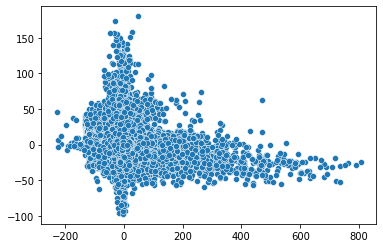

In [7]:
import pandas as pd
print("dyn X_pca shape:", adata.obsm["X_pca"].shape)
print("sc X_pca shape:", sc_adata.obsm["X_pca"].shape)

# sc_adata.X = adata.X
# sc_adata.var["use_for_pca"] = adata.var["use_for_pca"]
# preprocessor.pca(sc_adata, pca_key="X_pca", n_pca_components=50)

preprocess_genes = adata.var_names[adata.var[DKM.VAR_USE_FOR_PCA]]
sc_genes = sc_adata.var_names[sc_adata.var["highly_variable"]]

def benchmark_Xpca(adata, other_adata, key="X_pca"):
    plot_scatter_sparse(adata.obsm[key], other_adata.obsm[key])
benchmark_Xpca(adata[:, preprocess_genes], sc_adata[:, sc_genes])


print("dyn preprocessor adata.X stats:")
print(pd.Series(adata.X.data).describe())
print("original adata spliced stats:")
print(pd.Series(adata_origin.layers["spliced"].data).describe())
print("original adata.X stats:")
print(pd.Series(adata_origin.X.data).describe())
print("sc adata.X stats:")
print(pd.Series(sc_adata.X.data).describe())

# plot_scatter_sparse(adata.X, sc_adata.X, title="X comparison")

print("sc genes length:", len(sc_genes))
print("dyn preprocess genes:", len(preprocess_genes))
print("#different genes regarding highly variable genes:", len(set(sc_genes).difference(set(preprocess_genes))))
# assert not set(sc_genes).difference(set(preprocess_genes))
# assert not set(preprocess_genes).difference(set(sc_genes))

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [229.2768s]


<Figure size 1200x1200 with 0 Axes>

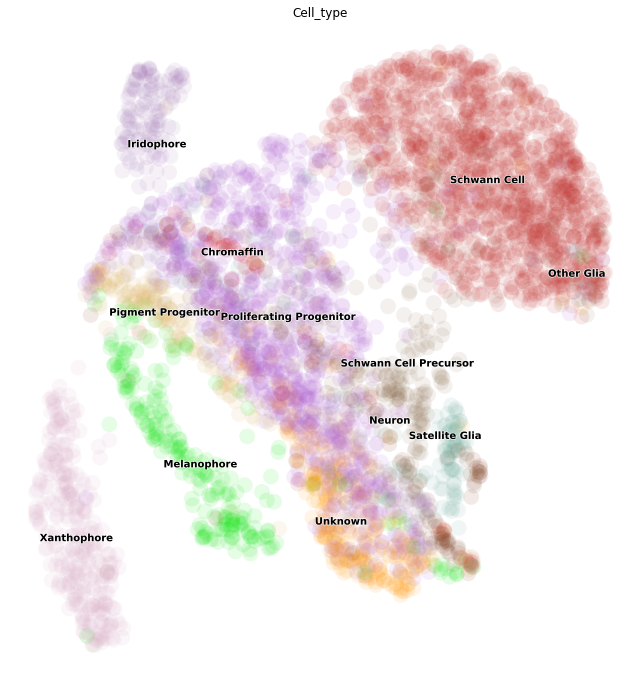

In [8]:


dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color=[celltype_key], figsize=(12, 12))


|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> Detecting community with initial_membership input from caller
|-----> [Community clustering with leiden] in progress: 100.0000%
|-----> [Community clustering with leiden] finished [244.5226s]


<Figure size 600x400 with 0 Axes>

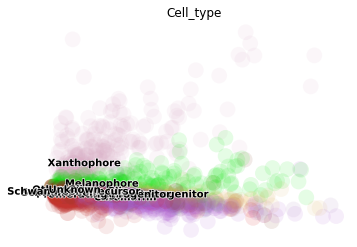

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [5.3232s]


<Figure size 600x400 with 0 Axes>

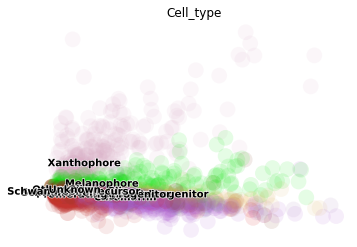

In [9]:
dyn.tl.leiden(adata, basis="pca")
dyn.pl.leiden(adata, basis="pca", color="Cell_type")
dyn.tl.louvain(adata, basis="pca")
dyn.pl.louvain(adata, basis="pca", color="Cell_type")

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [55.9758s]
|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.ind

<Figure size 600x400 with 0 Axes>

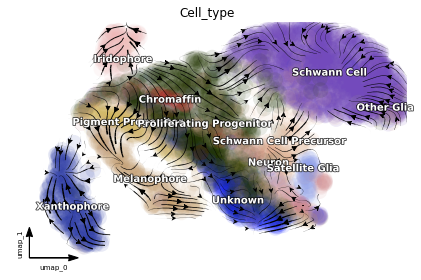

In [10]:
adata.layers["X_spliced"] = adata.layers["spliced"]
adata.layers["X_unspliced"] = adata.layers["unspliced"] 
adata.uns["pp"]["norm_method"] = "" 
dyn.tl.dynamics(adata, model='stochastic', cores=3)
dyn.pl.streamline_plot(adata, color=[celltype_key], basis='umap', show_legend='on data', show_arrowed_spines=True)


In [11]:
dyn.tl.reduceDimension(adata,basis="pca")
dyn.pp.cell_cycle_scores(adata)
dyn.pl.umap(adata, color=["louvain", celltype_key], figsize=(12, 12))
# adata

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0010s]
|-----> computing cell phase...
|-----> [cell phase estimation] in progress: 100.0000%
|-----> [cell phase estimation] finished [2.9488s]
|-----> <insert> cell_cycle_phase to obs in AnnData Object.


ValueError: cannot reindex from a duplicate axis

In [ ]:
dyn.tl.dynamics(adata, model='stochastic', cores=3) 

In [ ]:
dyn.pl.streamline_plot(adata, color=[celltype_key], basis='umap', show_legend='on data', show_arrowed_spines=True);


In [ ]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'])